In [6]:
import os
import glob
import zipfile
import functools
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
import imageio
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

# Datasets

In [7]:
img_dir = '../competition-data/training/images'
label_dir = '../competition-data/training/groundtruth'
test_dir = '../competition-data/test'

In [8]:
train_filenames = os.listdir(img_dir)
x_train_filenames = [os.path.join(img_dir, filename) for filename in train_filenames]
y_train_filenames = [os.path.join(label_dir, filename) for filename in train_filenames]
test_filenames = os.listdir(test_dir)
x_test_filenames = [os.path.join(test_dir, filename) for filename in test_filenames]

x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)
#kFold = KFold(n=len(x_train_filenames), n_folds=5, shuffle=True)

In [9]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 80
Number of validation examples: 20
Number of test examples: 94


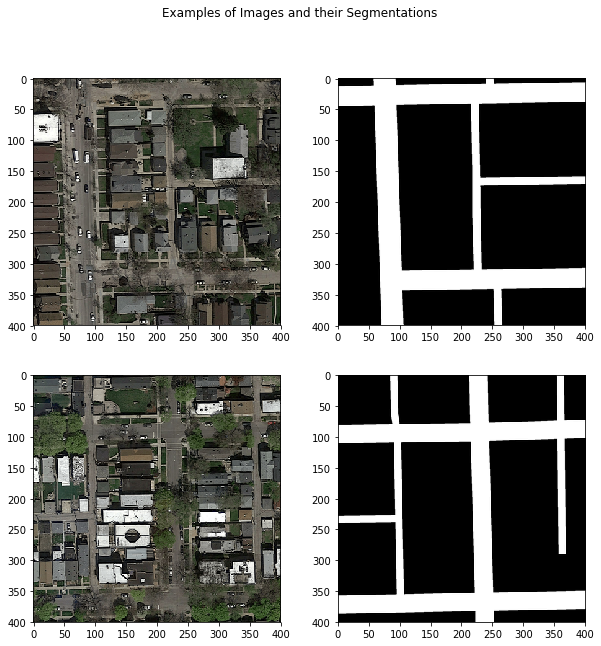

In [10]:
display_num = 2

r_choices = np.random.choice(num_train_examples, display_num)
plt.figure(figsize=(10, 10))

for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname), cmap="gray")  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(mpimg.imread(y_pathname), cmap="gray")

plt.suptitle("Examples of Images and their Segmentations")
plt.show()

In [11]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 100

In [12]:
def _process_pathnames(fname, label_path):
  """Load the image pair from given paths"""
  # We map this function onto each pathname pair  

  img_str = tf.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  return img, label_img

In [13]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
    if width_shift_range:
      width_shift_range = tf.random_uniform([], 
                                            -width_shift_range * img_shape[1],
                                            width_shift_range * img_shape[1])
    if height_shift_range:
      height_shift_range = tf.random_uniform([],
                                             -height_shift_range * img_shape[0],
                                             height_shift_range * img_shape[0])
    # Translate both 
    output_img = tfcontrib.image.translate(output_img,
                                           [width_shift_range, height_shift_range])
    label_img = tfcontrib.image.translate(label_img,
                                          [width_shift_range, height_shift_range])
  return output_img, label_img

In [14]:
def flip_img(horizontal_flip, tr_img, label_img):
  """Flip the image randomly"""
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [15]:
def rot90_img(rotate90, tr_img, label_img):
  """Rotating the image randomly in 90° angles"""
  if rotate90:
    rotate_count = tf.random_uniform([], 0, 4, dtype=tf.dtypes.int32)
    tr_img = tf.image.rot90(tr_img, rotate_count)
    label_img = tf.image.rot90(label_img, rotate_count)

  return tr_img, label_img

In [16]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             rotate90=False,  # Random number of 90° rotations
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)

  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)

  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = rot90_img(rotate90, img, label_img)
  #img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.cast(label_img, tf.dtypes.float32) * scale
  img = tf.cast(img, tf.dtypes.float32) * scale 
  return img, label_img

In [17]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True,
                         repeat=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

  if shuffle:
    dataset = dataset.shuffle(num_x)

  # It's necessary to repeat our data for all epochs
  if repeat:
    dataset = dataset.repeat()

  dataset = dataset.batch(batch_size)
    
  return dataset

In [18]:
tr_cfg = {
  'resize': [img_shape[0], img_shape[1]],
  'scale': 1 / 255.,
  'horizontal_flip': True,
  'rotate90': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

val_cfg = {
  'resize': [img_shape[0], img_shape[1]],
  'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [19]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.


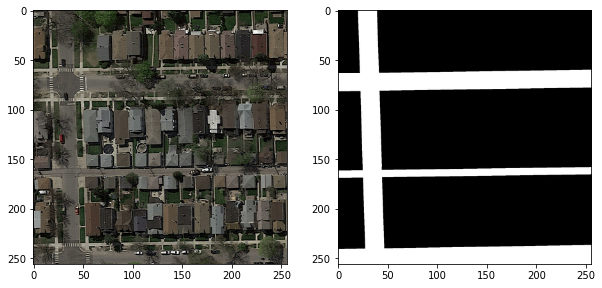

In [20]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0], cmap='gray')
  plt.show()

## Define Neural Network Architecture

In [74]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)

  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  print(decoder)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

def atrous_pyramid_block(input_tensor, num_filters, output_stride):
   # 1x1 Convolution
  atrous_branch_0 = layers.Conv2D(num_filters, (1, 1), padding='same')(input_tensor) 
  atrous_branch_0 = layers.BatchNormalization()(atrous_branch_0)
  atrous_branch_0 = layers.Activation('relu')(atrous_branch_0)
    
  # atrous rate 6
  atrous_branch_1 = layers.Conv2D(num_filters, (3, 3), dilation_rate=6, padding='same')(input_tensor)
  atrous_branch_1 = layers.BatchNormalization()(atrous_branch_1)
  atrous_branch_1 = layers.Activation('relu')(atrous_branch_1)
  # atrous rate 8
  atrous_branch_2 = layers.Conv2D(num_filters, (3, 3), dilation_rate=8, padding='same')(input_tensor)
  atrous_branch_2 = layers.BatchNormalization()(atrous_branch_2)
  atrous_branch_2 = layers.Activation('relu')(atrous_branch_2)

  # atrous rate 16
  atrous_branch_3 = layers.Conv2D(num_filters, (3, 3), dilation_rate=16, padding='same')(input_tensor)
  atrous_branch_3 = layers.BatchNormalization()(atrous_branch_3)
  atrous_branch_3 = layers.Activation('relu')(atrous_branch_3)
    
  # TODO: Add Image Feature
  
  # Concatenate branches
  concat = layers.Concatenate()([atrous_branch_0, atrous_branch_1, atrous_branch_2, atrous_branch_3])
  concat = layers.Conv2D(num_filters, (1, 1), padding='same')(concat)
  concat = layers.BatchNormalization()(concat)
  concat = layers.Activation('relu')(concat)
 

  return concat

A downward block consists of two convolutions where the dimension does not change and a reduction convolution at the end.
The output before the reducting convolution is saved for the skip connections.

In [75]:
def encoder_block(num_filters, input):
    
    encoder = layers.Conv2D(num_filters, (3,3), strides=(1, 1), padding="same", activation="relu")(input)
    encoder = layers.BatchNormalization()(encoder)
    
    encoder = layers.Conv2D(num_filters, (3,3), strides=(1, 1), padding="same", activation="relu")(encoder)
    encoder = layers.BatchNormalization()(encoder)

    skip = encoder
    
    encoder = layers.Conv2D(num_filters, (3,3), strides=(2, 2), padding="same", activation="relu")(encoder)
    encoder = layers.BatchNormalization()(encoder)

    print(encoder)
    return encoder, skip

def decoder_block(num_filters, input, skip):
    
    decoder = layers.Conv2DTranspose(num_filters, (3,3), strides=(2, 2), padding="same", activation="relu")(input)
    decoder = layers.Concatenate()([decoder, skip])
   
    decoder = layers.Conv2D(num_filters, (3,3), strides=(1, 1), padding="same", activation="relu")(decoder)
    decoder = layers.BatchNormalization()(decoder)
    
    decoder = layers.Conv2D(num_filters, (3,3), strides=(1, 1), padding="same", activation="relu")(decoder)
    decoder = layers.BatchNormalization()(decoder)

    print(decoder)

    return decoder


## Model

In [76]:
inputs = layers.Input(shape=img_shape)
skips = list()

# Encoding
encoder = inputs
for layer_idx in range(4):

    encoder, skip = encoder_block((1+layer_idx)*64, encoder)
    skips.append(skip)

# Pyramid with dilated convolutions

# Create four parallel convolved feature maps at different dilation rates.
first_map = layers.Conv2D(256, (1, 1))(encoder)
second_map = layers.Conv2D(256, (3,3), dilation_rate = 4, padding='same')(encoder)
third_map = layers.Conv2D(256, (3,3), dilation_rate = 8, padding='same')(encoder)
fourth_map = layers.Conv2D(256, (3,3), dilation_rate = 16, padding='same')(encoder)

# Feature channel with an upsampled average pooling
global_pooling = layers.AveragePooling2D(pool_size=(16, 16), strides=(1, 1))(encoder)
global_pooling = layers.UpSampling2D(size=(16, 16))(global_pooling)
global_pooling = layers.Conv2D(256, (1, 1))(global_pooling)

concat = layers.Concatenate()([first_map, second_map, third_map, fourth_map, global_pooling])
combined = layers.Conv2D(256, (1,1), padding="same")(concat)
print(combined)

# Decoding
decoder = encoder
for layer_idx in range(4):

    decoder= decoder_block((-1*(layer_idx-4)*64), decoder, skips[4-layer_idx-1])

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder)
outputs

Tensor("batch_normalization_v1_205/cond/Merge:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("batch_normalization_v1_208/cond/Merge:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("batch_normalization_v1_211/cond/Merge:0", shape=(?, 32, 32, 192), dtype=float32)
Tensor("batch_normalization_v1_214/cond/Merge:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("conv2d_389/BiasAdd:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("batch_normalization_v1_216/cond/Merge:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("batch_normalization_v1_218/cond/Merge:0", shape=(?, 64, 64, 192), dtype=float32)
Tensor("batch_normalization_v1_220/cond/Merge:0", shape=(?, 128, 128, 128), dtype=float32)
Tensor("batch_normalization_v1_222/cond/Merge:0", shape=(?, 256, 256, 64), dtype=float32)


<tf.Tensor 'conv2d_398/Sigmoid:0' shape=(?, 256, 256, 1) dtype=float32>

In [77]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [78]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [79]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

In [80]:
def bce_dice_loss(y_true, y_pred):
  loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

In [81]:
def root_mean_squared_error(y_true, y_pred):
  loss = tf.sqrt(losses.mean_squared_error(y_true, y_pred))
  return loss

In [84]:
model.compile(optimizer='adam', 
              loss=bce_dice_loss, 
              metrics=[dice_loss, root_mean_squared_error])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_372 (Conv2D)             (None, 256, 256, 64) 1792        input_35[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_203 (Bat (None, 256, 256, 64) 256         conv2d_372[0][0]                 
__________________________________________________________________________________________________
conv2d_373 (Conv2D)             (None, 256, 256, 64) 36928       batch_normalization_v1_203[0][0] 
__________________________________________________________________________________________________
batch_norm

In [85]:
save_model_path = 'weights_epoch{epoch:03d}_rmse{val_root_mean_squared_error:.4f}.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_root_mean_squared_error', save_best_only=True, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.01, patience=20, verbose=1, mode='auto', restore_best_weights=True)


In [86]:
history = model.fit(train_ds, 
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp, es])

Epoch 1/100
26/27 [===========================>..] - ETA: 14s - loss: 4.0979 - dice_loss: 0.6620 - root_mean_squared_error: 0.4107
Epoch 00001: val_root_mean_squared_error improved from inf to 0.51691, saving model to weights_epoch001_rmse0.5169.hdf5
27/27 [==============================] - 459s 17s/step - loss: 4.0740 - dice_loss: 0.6596 - root_mean_squared_error: 0.4088 - val_loss: 4.5275 - val_dice_loss: 0.7065 - val_root_mean_squared_error: 0.5169
Epoch 2/100
26/27 [===========================>..] - ETA: 15s - loss: 3.4498 - dice_loss: 0.5904 - root_mean_squared_error: 0.3293
Epoch 00002: val_root_mean_squared_error did not improve from 0.51691
27/27 [==============================] - 445s 16s/step - loss: 3.4404 - dice_loss: 0.5902 - root_mean_squared_error: 0.3277 - val_loss: 40.3475 - val_dice_loss: 0.6760 - val_root_mean_squared_error: 0.8048
Epoch 3/100
26/27 [===========================>..] - ETA: 15s - loss: 3.0091 - dice_loss: 0.5333 - root_mean_squared_error: 0.2671
Epoch 

27/27 [==============================] - 525s 19s/step - loss: 1.7026 - dice_loss: 0.3112 - root_mean_squared_error: 0.1037 - val_loss: 2.9351 - val_dice_loss: 0.5292 - val_root_mean_squared_error: 0.1873
Epoch 21/100
26/27 [===========================>..] - ETA: 17s - loss: 1.6240 - dice_loss: 0.3066 - root_mean_squared_error: 0.0990
Epoch 00021: val_root_mean_squared_error improved from 0.18733 to 0.16954, saving model to weights_epoch021_rmse0.1695.hdf5
27/27 [==============================] - 522s 19s/step - loss: 1.6211 - dice_loss: 0.3056 - root_mean_squared_error: 0.0988 - val_loss: 4.0335 - val_dice_loss: 0.5894 - val_root_mean_squared_error: 0.1695
Epoch 22/100
26/27 [===========================>..] - ETA: 19s - loss: 1.6191 - dice_loss: 0.3009 - root_mean_squared_error: 0.0958
Epoch 00022: val_root_mean_squared_error did not improve from 0.16954
27/27 [==============================] - 545s 20s/step - loss: 1.6098 - dice_loss: 0.2991 - root_mean_squared_error: 0.0951 - val_lo

26/27 [===========================>..] - ETA: 14s - loss: 1.3602 - dice_loss: 0.2492 - root_mean_squared_error: 0.0771
Epoch 00040: val_root_mean_squared_error did not improve from 0.09410
27/27 [==============================] - 421s 16s/step - loss: 1.3472 - dice_loss: 0.2469 - root_mean_squared_error: 0.0763 - val_loss: 2.5591 - val_dice_loss: 0.3838 - val_root_mean_squared_error: 0.1118
Epoch 41/100
26/27 [===========================>..] - ETA: 14s - loss: 1.3674 - dice_loss: 0.2537 - root_mean_squared_error: 0.0747
Epoch 00041: val_root_mean_squared_error did not improve from 0.09410
27/27 [==============================] - 420s 16s/step - loss: 1.3550 - dice_loss: 0.2509 - root_mean_squared_error: 0.0740 - val_loss: 1.9162 - val_dice_loss: 0.2878 - val_root_mean_squared_error: 0.1001
Epoch 42/100
26/27 [===========================>..] - ETA: 14s - loss: 1.3983 - dice_loss: 0.2555 - root_mean_squared_error: 0.0789
Epoch 00042: val_root_mean_squared_error improved from 0.09410 to 0

Epoch 60/100
26/27 [===========================>..] - ETA: 14s - loss: 1.1692 - dice_loss: 0.2095 - root_mean_squared_error: 0.0615
Epoch 00060: val_root_mean_squared_error did not improve from 0.06946
27/27 [==============================] - 420s 16s/step - loss: 1.1785 - dice_loss: 0.2108 - root_mean_squared_error: 0.0619 - val_loss: 2.6122 - val_dice_loss: 0.4317 - val_root_mean_squared_error: 0.1093
Epoch 61/100
26/27 [===========================>..] - ETA: 14s - loss: 1.2893 - dice_loss: 0.2364 - root_mean_squared_error: 0.0695
Epoch 00061: val_root_mean_squared_error did not improve from 0.06946
27/27 [==============================] - 420s 16s/step - loss: 1.2802 - dice_loss: 0.2347 - root_mean_squared_error: 0.0691 - val_loss: 1.5366 - val_dice_loss: 0.2569 - val_root_mean_squared_error: 0.0868
Epoch 62/100
26/27 [===========================>..] - ETA: 14s - loss: 1.1204 - dice_loss: 0.1990 - root_mean_squared_error: 0.0591
Epoch 00062: val_root_mean_squared_error did not impro

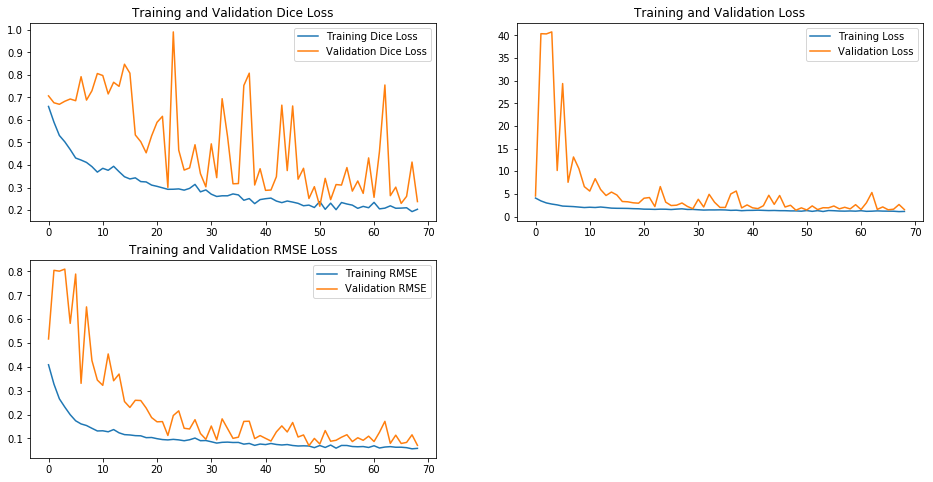

In [87]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation RMSE Loss')

plt.show()

In [88]:
# Load weights from latest checkpoint
model_path = sorted(glob.glob('weights*'), reverse=True)[0]
model = models.load_model(model_path, custom_objects={'root_mean_squared_error': root_mean_squared_error,
                                                           'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})
# Alternatively, load the weights directly: 
#model.load_weights(model_path)
print("Loaded model from:", model_path)



Loaded model from: weights_epoch049_rmse0.0695.hdf5


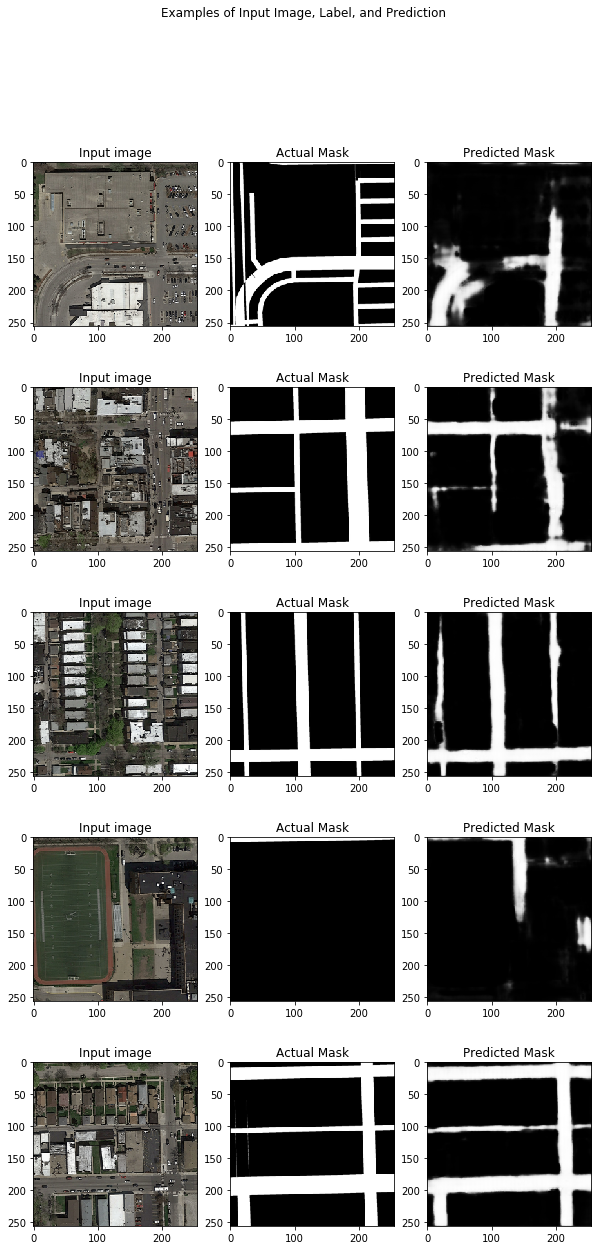

In [89]:
# Visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0], cmap='gray')
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0], cmap='gray')
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

In [90]:
# create directory for predictions
prediction_dir = model_path
prediction_dir = prediction_dir.replace("weights", "predictions", 1).replace(".hdf5", "", 1)
os.mkdir(prediction_dir)

test_ds = get_baseline_dataset(x_test_filenames,
                               x_test_filenames, 
                               preproc_fn=val_preprocessing_fn,
                               batch_size=batch_size,
                               shuffle=False,
                               repeat=False)

data_aug_iter = test_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
count=0

sess = tf.keras.backend.get_session()
try:
  while True:
    batch_of_imgs, label = sess.run(next_element)
    predicted_labels = model.predict(batch_of_imgs)
    
    # rescale images from [0, 1] to [0, 255]
    predicted_labels = predicted_labels / val_cfg['scale']

    for i in range(len(predicted_labels)):
      pred = Image.fromarray(predicted_labels[i, :, :, 0], 'F').resize((608, 608)).convert('L')
      imageio.imwrite(os.path.join(prediction_dir, test_filenames[count]), pred)
      count += 1

except tf.errors.OutOfRangeError:
  pass

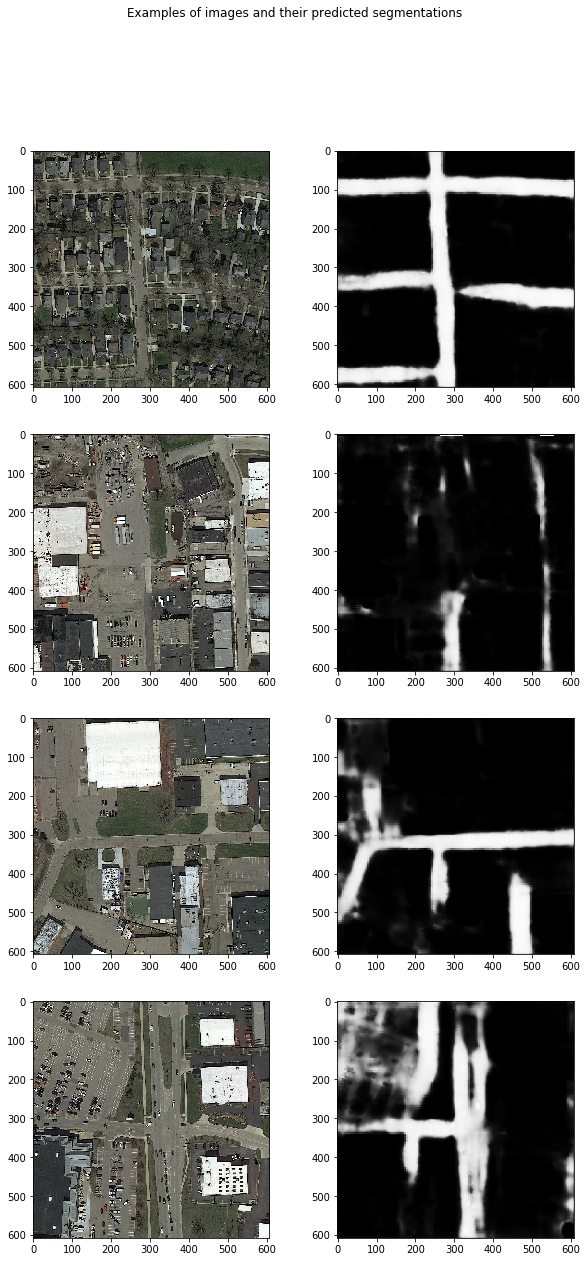

In [110]:
# Show some of the predictions
display_num = 4

r_choices = np.random.choice(len(test_filenames), display_num)
plt.figure(figsize=(10, 20))

for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_test_filenames[img_num]
  y_pathname = os.path.join(prediction_dir, test_filenames[img_num])
  
  image = mpimg.imread(y_pathname)
  r=0
  for row in image:
    j=0
    for pixel in row:
        if pixel<0.1:
            image[r][j]=0
        else:
            image[r][j]=1
        j=j+1
    r=i+1
            
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname), cmap="gray")  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(image, cmap="gray")

plt.suptitle("Examples of images and their predicted segmentations")
plt.show()

In [114]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
  df = np.mean(patch)
  if df > foreground_threshold:
    return 1
  else:
    return 0


def mask_to_submission_strings(image_filename):
  """Reads a single image and outputs the strings that should go into the submission file"""
  img_number = int(re.search(r"\d+(?=\.png$)", image_filename).group(0))
  im = mpimg.imread(image_filename)
  patch_size = 16
  for j in range(0, im.shape[1], patch_size):
    for i in range(0, im.shape[0], patch_size):
      patch = im[i:i + patch_size, j:j + patch_size]
      label = patch_to_label(patch)
      yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
  """Converts images into a submission file"""
  with open(submission_filename, 'w') as f:
    f.write('id,prediction\n')
    for fn in image_filenames[0:]:
      f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

In [115]:
submission_filename = model_path.replace("weights", "submission", 1).replace(".hdf5", ".csv", 1)
image_filenames = [os.path.join(prediction_dir, filename) for filename in os.listdir(prediction_dir)]
masks_to_submission(submission_filename, *image_filenames)

In [116]:
print("Validating submission file:", submission_filename)
df = pd.read_csv(submission_filename)

print('Shape of csv:', df.shape)
assert df.shape == (135736, 2), "Invalid number of rows or columns in submission file!"
assert df['id'].unique().size == 135736, "Column 'id' should contain 135736 unique values!"

meanPred = df['prediction'].mean()
print("Mean prediction: {:.3f}".format(meanPred))
assert meanPred > 0.05 and meanPred < 0.3, "Very unlikely mean prediction!"

print("Submission file looks OKAY!")

Validating submission file: submission_epoch049_rmse0.0695.csv
Shape of csv: (135736, 2)
Mean prediction: 0.172
Submission file looks OKAY!
